In [217]:
# import modules & set up logging
# import gensim, logging
# from sortedcontainers import SortedDict
# from gensim.models import KeyedVectors
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import unidecode
# import pickle
import re
# import random
import pandas as pd
# import numpy as np
# import seaborn as sns
# from tqdm import tqdm
# import glob, os
import pybootstrap as pb
# from scipy.stats.stats import pearsonr
import pymc3 as pm
# from scipy.spatial.distance import cosine as cosine_distance
# from aligning_embeddings import *
# from w2vtransformation import *
# from relation import *
from helper import *
# import zipfile
# import datetime
# import urllib.request
# import os.path
# from umap import UMAP # actually called "umap-learn"
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

In [ ]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [222]:
#configure plotting
figures_path = '../figures/'
%matplotlib inline
plt.style.use('bmh')
plt.style.use('grayscale')


# Loading models

In [ ]:
models_vk = load_models('vk', 10, align=True)
models_telegraaf = load_models('telegraaf', 10, align=True)
models_ah_nrc = load_models('ah_nrc', 10, align=True)
models_trouw = load_models('trouw', 10, align=True)
models_parool = load_models('parool', 10, align=True)
models_vv = load_models('vv', 10, align=True)

embeddings = [models_vk, models_telegraaf, models_ah_nrc, models_trouw,
                             models_parool, models_vv]
embedding_names = ['vk', 'telegraaf', 'nrc', 'trouw', 'parool', 'vv']
years = ['1950', '1960', '1970', '1980']
#years = ['1950', '1955', '1960', '1965', '1970', '1975', '1980','1985']

In [ ]:
# Load names from Meertens Voornamenbank
names_df = pd.read_csv('../data/names/names.csv')
male_names = names_df['male_names'].apply(lambda x: unidecode.unidecode(x)).str.lower().values
female_names = names_df['female_names'].apply(lambda x: unidecode.unidecode(x)).str.lower().values

In [ ]:
# Definite male and female referents
male_words = ['hij','vader', 'opa', 'zoon', 'man', 'mannen', 'heer']
female_words = ['zij', 'moeder', 'oma', 'dochter', 'vrouw', 'vrouwen', 'dame']

In [ ]:
#Combination of names and referents
male_x = male_words + list(male_names)
female_x = female_words + list(female_names)

In [ ]:
'''
lists of jobs from HISCO dataset
'''
hisco = pd.read_csv('../data/hisco/hsn2013a_hisco_comma.csv')
hisco['len'] = hisco['Standard'].str.split().apply(lambda x: len(x))
job_titles = hisco[hisco['len'] == 1]['Standard'].drop_duplicates().values
print("length jobs: {}".format(len(job_titles)))

In [ ]:
'''
Emotions with polarities from Cornetto
'''

emotions = pd.read_csv('../data/cornetto/emotion_cornetto.csv')
emotions.drop_duplicates(subset=['word'], keep='first', inplace=True)
#emotions = emotions[emotions['polarity'] != 0]

emotions['word'] = emotions['word'].apply(lambda x: unidecode.unidecode(x))
emotion_words = emotions[emotions['confidence'] == 1.0]['word'].values

In [ ]:
pos_words = emotions[emotions['polarity'] >= 0.5]['word'].values
neg_words = emotions[emotions['polarity'] <= -0.5]['word'].values
print("length positive_words: {}".format(len(pos_words)))
print("length negative_words: {}".format(len(neg_words)))

Selected the following categories
* Psychological Processes
    * Affective or Emotional Processes
        * Positive emotions
            * Positive feelings
            * Optimism and energy
        * Negative emotions
            * Anxiety or feat
            * Anger
            * Sadness or depression
    * Cognitive mechanisms
        * Insight
        * Causation
        * Discrepancy
        * Tentative
        * Certainty
        * Inhibition
    * Sensory and Perceptual Process
        * Seeing
        * Hearing
        * Feeling
    * Social Processes
        * Communication
        * Other references to people
        * Friends
        * Family
        * Humans
* Personal Concerns
    * Occupation
        * School
        * Job or work
        * Achievement
    * Leisure 
        * Home
        * Sports
        * Television and movies
        * Music
    * Money and financial issues
    * Metaphysical issues
        * Religion
        * Death and dying
    * Physical states and function
        * Body states, symptoms
        * Sex and sexuality
        * Eating, drinking, dieting
        * Sleeping, dreaming
        * Grooming

In [ ]:
'''
Dutch translation of LIWC 2001
'''
LIWC = pd.read_csv('../data/LIWC/LIWC_Dutch.csv')
for col in LIWC.columns:
    try:
        LIWC[col] = LIWC[col].astype(str).apply(lambda x: unidecode.unidecode(x)).values
        LIWC[col] = LIWC[col].astype(str).map(lambda x: x.rstrip('*'))
    except:
        pass

# list of all LIWC words
LIWC_list = []
for col in LIWC.columns:
    sublist = LIWC[col].dropna().tolist()
    for word in sublist: 
        word = re.sub("\*", '', word)
        LIWC_list.append(word)

selected_cols = ['Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 
                 'Senses', 'Social', 'Occup', 'Leisure', 'Home', 'Sports', 'TV',
                 'Music', 'Money', 'Metaph','Physcal','Body','Sexual', 'Eating', 'Sleep', 'Groom']
LIWC = LIWC[selected_cols]

# Frequency

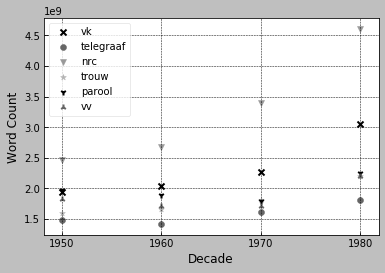

In [225]:
fmts = ['x', 'o', 'v', '*', '1', '2', '3']
for i, model in enumerate(embeddings):  
    model_name = embedding_names[i]
    counts = []
    for m in model:
        count = 0
        for word in m.vocab.keys():
            count += m.vocab[word].count
        counts.append(count)
    plt.scatter(years, counts, label=model_name, marker=fmts[i])
#plt.yscale('log')
#plt.title("Vocabulary Size per Embedding")
plt.xlabel('Decade')
plt.ylabel('Word Count')
plt.legend()
plt.savefig(figures_path + 'vocab_size.png')

In [ ]:
seeds_ = [LIWC_list, job_titles, pos_words, neg_words]
seed_names = ['LIWC', 'job_titles', 'positive_words', 'negative_words']


fig, axis = plt.subplots(2, 3, figsize=(10, 5), sharey=True, sharex=True)
axis = axis.ravel()

for i, model in enumerate(embeddings):
    model_name = embedding_names[i]
    counts_list = {}
    for name, list_ in zip(seed_names, seeds_):
        counts_avg = []
        for m in model:
            counts = []
            for word in list_:
                try:
                    counts.append(m.vocab[word].count)
                except: 
                    pass
            counts_avg.append(np.mean(counts))
        counts_list[name] = counts_avg

    for name in seed_names:
        axis[i].scatter(years, counts_list[name], label=name)
        axis[i].set_title(model_name)
        
    if not i%6:
        
        axis[i].set_ylabel('Word Counts')
plt.legend(bbox_to_anchor=(2.1, 2.25), loc='upper right', ncol=1)
plt.savefig(figures_path + 'target_words_count.png')

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(10, 5), sharey=True, sharex=True)
axis = axis.ravel()

for i, model in enumerate(embeddings):
    model_name = embedding_names[i]
    counts_list = {}
    for name, list_ in zip(seed_names, seeds_):
        counts_avg = []
        for m in model:
            counts = []
            for word in list_:
                try:
                    counts.append(m[word])
                except: 
                    pass
            counts_avg.append(np.mean(np.var(counts, axis=0)))
        counts_list[name] = counts_avg

    for name in seed_names:
        axis[i].plot(years, counts_list[name], label=name)
        axis[i].set_title(model_name)
    if not i%6:
        axis[i].legend()
        axis[i].set_ylabel('Variance')
plt.savefig(figures_path + 'variance.png')

## Employment Netherlands

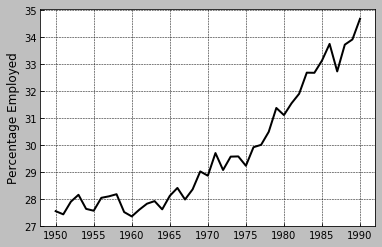

In [224]:
employment = pd.read_csv('../data/beroepsbevolking/Beroepsbevolking_1800_2013.csv', sep=';')
employment['beroepsbevolking'] = employment['Werkzame beroepsbevolking/Werkzame beroepsbevolking (x 1 000)']

#group by decade
#male_employment = employment[employment['Geslacht'] == 'Mannen'].groupby((employment['Perioden']//10)*10).sum()['beroepsbevolking'].values[:-1]
#female_employment = employment[employment['Geslacht'] == 'Vrouwen'].groupby((employment['Perioden']//10)*10).sum()['beroepsbevolking'].values[:-1]

male_employment = employment[employment['Geslacht'] == 'Mannen']['beroepsbevolking'].values
female_employment = employment[employment['Geslacht'] == 'Vrouwen']['beroepsbevolking'].values

p = female_employment/(male_employment + female_employment) * 100
#logit_prop = np.log(p/(1-p))
plt.ylabel("Percentage Employed")
#plt.xlabel("Years")
#plt.title("Female Employment Numbers")
plt.plot(range(1950,1991),p)
plt.savefig(figures_path + 'female_employment.png')

# BIAS

Taken from Garg et al. <br>
More generally, we compute the representative group vector by taking the average of the vectors for each word in the given gender/ethnicity group. Then we compute the average Euclidean distance between each repre- sentative group vector and each vector in the neutral word list of interest, which could be occupations or adjectives. The difference of the average distances is our metric for bias—we call this the relative norm difference or simply embedding bias.

In [ ]:
def plot_bias(list1, list2, target_words, name):
    plt.clf()
    for index, model in enumerate(embeddings):
        fmts = ['x', 'o', 'v', '.', '*', '1', '2', '3']
        C, means, bounds = embedding_bias(list1, list2, target_words, model)
        x = range(1950 + index, 1990 + index, 10)
        y = np.array(means)
        bounds = np.array(bounds).T
        errors = np.zeros_like(bounds)
        errors[0,:] = y - bounds[0,:]
        errors[1,:] = bounds[1,:] - y
        plt.errorbar(x, y=means, yerr=errors, fmt=fmts[index], label=embedding_names[index])
        plt.ylabel('Embedding Bias')
        #plt.ylim(-0.1, 0.1)
        plt.legend()
        plt.savefig(figures_path + 'mean_bias_{}.png'.format(name))

In [ ]:
def embedding_bias(list1, list2, features, models):
    means = []
    bounds = []
    values = []
    year = []
    for index, model in enumerate(models):       
        v1 = np.mean([model[word] for word in list1 if word in model.vocab], axis=0)
        #v = calculate_vectors(model, male_words, female_words)
        v2 = np.mean([model[word] for word in list2 if word in model.vocab], axis=0)
        x = []
        y = []
        for word in features:
            try:
                x.append(calc_distance_between_vectors(v1, model[word]))
                y.append(calc_distance_between_vectors(v2, model[word]))
            except:
                pass
        C = [x_ - y_ for x_, y_ in zip(x, y)]
        values.append(C)
        means.append(np.mean(C))
        bounds.append(pb.bootstrap(C, confidence=0.95, iterations=1000, sample_size=.9, statistic=np.mean))
    return values, means, bounds

In [ ]:
# for col in LIWC.columns:
#     name = str(col)
#     plot_bias(male_x, female_x, LIWC[col], name)

names = ['job_titles', 'pos_words', 'neg_words']

for index, group in enumerate([job_titles, pos_words, neg_words]):
    plot_bias(male_x, female_x, group, names[index])


## Calculate distances

In [ ]:
def calculate_distances(list1, list2, target_words):
    distance_m = []
    distance_f = []
    titles_ = []
    years_ = []
    variances = []
    words = []
    counts = []
    for index, models in enumerate(embeddings):
        title = embedding_names[index]
        for i, model in enumerate(models):
            variance = []
            year = years[i]
            v_male = calculate_vector(model, list1)
            v_female = calculate_vector(model, list2)
            x = []     
            for word in target_words:
                #if word not in male_words and word not in female_words:
                try:
                    distance_m.append(calc_distance_between_vectors(v_male, model[word]))
                    distance_f.append(calc_distance_between_vectors(v_female, model[word]))
                    variance.append(model[word])
                    counts.append(model.vocab[word].count)
                    words.append(word)
                    years_.append(year)
                    titles_.append(title)
                #y.append(cossim(v2, model[word]))
                except:
                    pass
    df = pd.DataFrame(list(zip(distance_m, distance_f, words, counts, years_, titles_)), columns=['distance_m', 'distance_f', 'words', 'counts', 'years', 'titles'])
    df['bias'] = df['distance_m'] - df['distance_f']
    df['years'] = df['years'].astype(int)
    df['years.s'] = (df['years'] - df['years'].mean()) / df['years'].std()
    df['bias.s'] = (df['bias'] - df['bias'].mean()) / df['bias'].std()
    df['counts_log'] = np.log(df['counts'])
    df['counts.s'] = (df['counts_log'] - df['counts_log'].mean()) / df['counts_log'].std()
    df['total'] = df['counts'].groupby(df['years']).transform('sum')
    df['total.s'] = (df['total'] - df['total'].mean()) / df['total'].std()
    df['years.c'] = df['years'].replace([1950, 1960, 1970, 1980], [0, 1, 2, 3])
    #remove low frequent words
    df = df[df['counts'] >= 10**4]
    return df

# Model Comparison

In [ ]:
df = calculate_distances(male_x, female_x, job_titles)

In [ ]:
with pm.Model() as model_a:
    '''
    Model with only intercept
    '''
    a = pm.Normal('a', mu=0, sd=2)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', a)
    bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
    trace_a = pm.sample(samples=5000, tune=1500, chains=4)

with pm.Model() as model_b:
    '''
    Model with years
    '''
    a = pm.Normal('a', mu=0, sd=2)
    bY = pm.Normal('bY', mu=0, sd=2)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', a + bY * df['years.c'])
    bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
    trace_b = pm.sample(samples=5000, tune=1500, chains=4)

\begin{tabular}{lrrrrrrr}
\toprule
{} &   mean &     sd &  mc\_error &  hpd\_2.5 &  hpd\_97.5 &     n\_eff &   Rhat \\
\midrule
a     & -0.164 &  0.010 &       0.0 &   -0.185 &    -0.145 &  1315.073 &  1.000 \\
bY    &  0.046 &  0.006 &       0.0 &    0.033 &     0.055 &  1261.437 &  0.999 \\
sigma &  1.001 &  0.005 &       0.0 &    0.992 &     1.010 &  1035.282 &  1.003 \\
\bottomrule
\end{tabular}



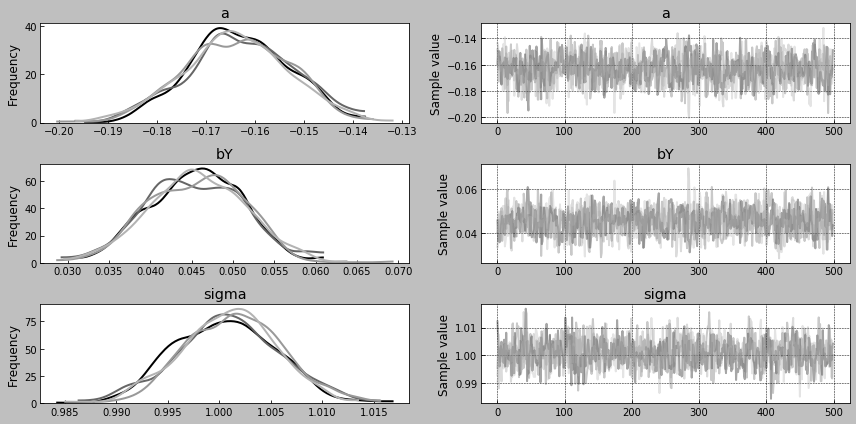

In [227]:
varnames = ['a', 'bY', 'sigma']
pm.traceplot(trace_b, varnames);
print(pm.summary(trace_b, varnames).round(3).to_latex())

In [226]:
comp_df = (pm.compare({
    model_a: trace_a,
    model_b: trace_b,

}).rename({0: "Model A",
           1: "Model B",
             }))
print(comp_df.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &     WAIC & pWAIC &  dWAIC & weight &      SE &   dSE & var\_warn \\
\midrule
Model B &  64624.8 &   2.9 &      0 &   0.99 &   201.6 &     0 &        0 \\
Model A &  64682.1 &  1.88 &  57.28 &   0.01 &  201.36 &  15.2 &        0 \\
\bottomrule
\end{tabular}



# Bayesian Linear Regression

In [ ]:
def make_linear_model(df, samples=5000, tune=1500, chains=4):
    with pm.Model() as model:
        a = pm.Normal('a', mu=0, sd=2)
        bY = pm.Normal('bY', mu=0, sd=2)
        #bC = pm.Normal('bC', mu=0, sd=2)
        sigma = pm.HalfCauchy('sigma', beta=1)
        mu = pm.Deterministic('mu', a + bY * df['years.c'])
        bias = pm.Normal('Distance', mu=mu, sd=sigma, observed=df['bias.s'])
        trace = pm.sample(progressbar=False, samples=samples, tune=tune, chains=chains)      
    return trace

def plot_linear(trace, name):
    plt.clf()
    seq_x = np.arange(-.5, 3.5, 0.05)
    mu_pred = np.zeros((len(seq_x), len(trace['bY'])))
    for i_seq, seq in enumerate(seq_x):
        mu_pred[i_seq] = trace['a'] + trace['bY'] * seq_x[i_seq]

    mu_mean = mu_pred.mean(1)
    mu_hpd = pm.hpd(mu_pred.T, alpha=0.05)

    plt.scatter(df['years.c'], df['bias.s'], facecolors='none', edgecolors='grey')
    plt.plot(seq_x, mu_mean, 'C0')
    plt.xticks([0, 1, 2, 3], years, rotation=45)
    plt.fill_between(seq_x, mu_hpd[:,0], mu_hpd[:,1], color='C0', alpha=0.3)
    plt.ylabel('Bias (m - / f +)')
    plt.ylim(-5, 5)
    #plt.xticks(np.arange(1950, 1980, 10))
    plt.xlabel('Years', fontsize=14);
    #plt.title(name)
    plt.savefig(figures_path + 'combined_{}.png'.format(name))

## Combined Linear Model

Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


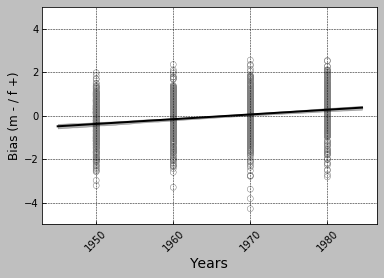

In [228]:
#targets_ = [pos_words, neg_words, job_titles]
#names = ['positive_words', 'negative_words', 'job_titles']
varnames = ['a', 'bY']
summary_combined = {}
for i, target in enumerate(targets_):
    name = names[i]
    print(name)
    df = calculate_distances(male_x, female_x, target)

    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    trace = make_linear_model(df, chains=1)
    summary_combined[name] = pm.summary(trace, varnames).round(3)
    plot_linear(trace, name)

Affect


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Posemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Negemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Anx


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Anger


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sad


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Senses


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Social


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Occup


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Leisure


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Home


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sports


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


TV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Music


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Money


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Metaph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Physcal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Body


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Eating


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sleep


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


Groom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks


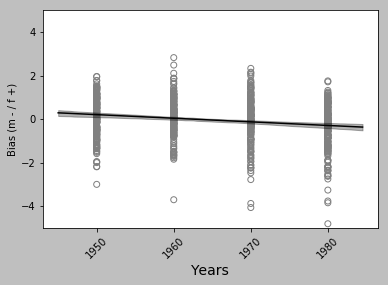

In [32]:
for col in LIWC.columns:
    name = str(col)
    print(name)
    df = calculate_distances(male_x, female_x, LIWC[col])
    
    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    try:
        trace = make_linear_model(df, chains=1)
        summary_combined[name] = pm.summary(trace, varnames).round(3)
        plot_linear(trace, name)
    except:
        pass
  
    

In [33]:
model_summary = pd.concat(summary_combined.values(), keys=summary_combined.keys())
model_summary.drop(['mc_error'], axis=1, inplace=True)
print(model_summary.to_latex())

# print(df.loc[['TV', 'Sexual', 'Occup', 'occupations', 
#               'negative_words', 'Occupations', 'TV', 'Music', 'Money', 
#               'Metaph', 'Groom']].to_latex())

\begin{tabular}{llrrrr}
\toprule
      &    &   mean &     sd &  hpd\_2.5 &  hpd\_97.5 \\
\midrule
positive\_words & a & -0.009 &  0.018 &   -0.042 &     0.026 \\
      & bY & -0.023 &  0.010 &   -0.042 &    -0.004 \\
negative\_words & a &  0.193 &  0.017 &    0.158 &     0.224 \\
      & bY & -0.157 &  0.009 &   -0.175 &    -0.141 \\
job\_titles & a & -0.164 &  0.011 &   -0.185 &    -0.142 \\
      & bY &  0.046 &  0.006 &    0.035 &     0.059 \\
Affect & a &  0.198 &  0.023 &    0.156 &     0.241 \\
      & bY & -0.162 &  0.012 &   -0.185 &    -0.139 \\
Posemo & a &  0.104 &  0.022 &    0.064 &     0.147 \\
      & bY & -0.098 &  0.012 &   -0.121 &    -0.076 \\
Negemo & a &  0.251 &  0.024 &    0.203 &     0.296 \\
      & bY & -0.194 &  0.012 &   -0.218 &    -0.171 \\
Anx & a &  0.309 &  0.027 &    0.256 &     0.357 \\
      & bY & -0.232 &  0.015 &   -0.261 &    -0.203 \\
Anger & a &  0.184 &  0.027 &    0.130 &     0.236 \\
      & bY & -0.150 &  0.014 &   -0.174 &    -0.121 \\
Sa

### Individual Newspapers

In [34]:
def individual_newspapers(df, sample=5000, tune=1500, chains=1):
    summary_individual = {}
    indiv_traces = {}

    for newspaper in newspaper_names:
        c_data = df.loc[df['titles'] == newspaper]
        c_data = c_data.reset_index(drop=True)

        c_bias = c_data['bias.s']
        c_years = c_data['years.c'].values
        c_counts = c_data['counts.s'].values

        with pm.Model() as individual_model:
            a = pm.Normal('a', mu=0, sd=2)
            bY = pm.Normal('bY', mu=0, sd=2)
            #bc = pm.Normal('beta_c', mu=0, sd=1)
            sigma = pm.HalfCauchy('eps', beta=1)

            #bias_est = a + b * c_years + bc * c_counts
            bias_est = a + bY * c_years
            y_like = pm.Normal('y_like', mu=bias_est, sd=sigma, observed=c_bias)

            trace = pm.sample(progressbar=False, sample=sample, tune=tune, chains=chains)
        indiv_traces[newspaper] = trace
        summary_individual[newspaper] = pm.summary(trace, varnames).round(3)
    return indiv_traces, summary_individual

In [35]:
def plot_individual_traces(traces, name):
    plt.clf()
    fig, axis = plt.subplots(3, 2, figsize=(10, 15), sharey=True, sharex=False)
    axis = axis.ravel()
    for i, c in enumerate(newspaper_names):
        c_data = df.loc[df['titles'] == c]
        c_data = c_data.reset_index(drop = True)
        z = list(c_data['newspaper_id'])[0]

        xvals = np.linspace(-0.5, 3.5)
        for a_val, b_val in zip(traces[c]['a'][::20], 
                                        traces[c]['bY'][::20]
                                        ):
            axis[i].plot(xvals, a_val + b_val * xvals, 
                         'grey', alpha=.2)

        axis[i].plot(xvals, traces[c]['a'][::10].mean() + 
                     traces[c]['bY'][::10].mean() * xvals, 
                     'black', alpha=1, lw=2., label='Regressions')
        axis[i].scatter(c_data['years.c'].values + 
                        np.random.randn(len(c_data))*0.01, 
                        c_data['bias.s'], alpha=1, color='k', 
                        marker='.', s=80, label='original data')
        axis[i].set_xticks([0, 1, 2, 3])
        axis[i].set_xticklabels(years, rotation=45)
        axis[i].set_ylim(-5, 5)
        axis[i].set_title(c)
        if not i%6:
            axis[i].legend()
            axis[i].set_ylabel('Bias (m - / f +)')
        #fig.suptitle(name)
        plt.savefig(figures_path + 'indiv_{}.png'.format(name))

Affect


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
The acceptance probability does not match the target. It is 0.8787063800312215, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to 

Posemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Negemo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Anx


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Anger


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Sad


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Senses


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
The acceptance probability does not match the target. It is 0.7185801502499459, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to 

Social


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
The acceptance probability does not match the target. It is 0.7035916790317067, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to 

Occup


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Leisure


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Home


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Sports


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

TV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Music


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Money


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Metaph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Physcal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Body


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Eating


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Sleep


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

Groom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

<Figure size 432x288 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

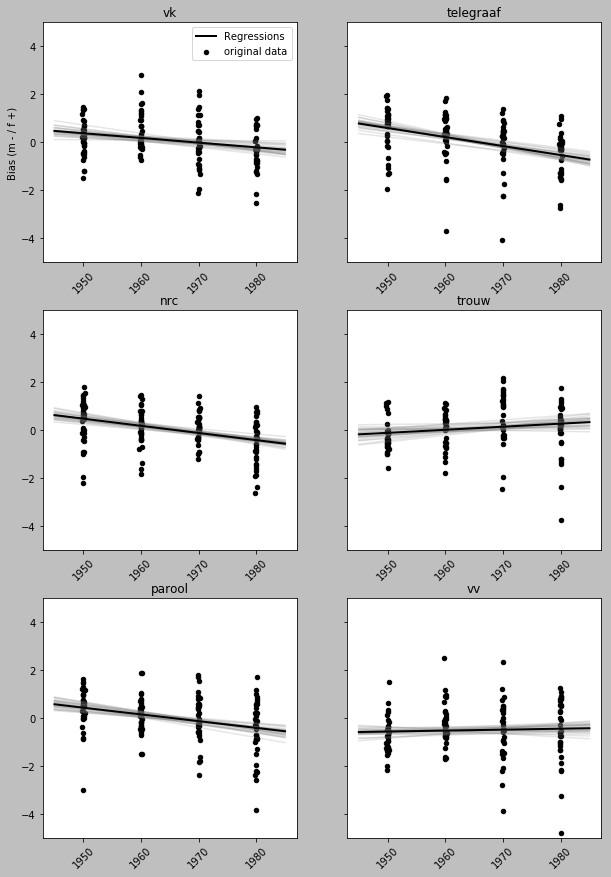

In [121]:
summaries = {}
for col in LIWC.columns:
    name = str(col)
    print(name)
    df = calculate_distances(male_x, female_x, LIWC[col])
    
    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    traces, summary = individual_newspapers(df, chains=1)
    summaries[name] = summary
    plot_individual_traces(traces, name)

Sexual


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, bY, a]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [e

<Figure size 432x288 with 0 Axes>

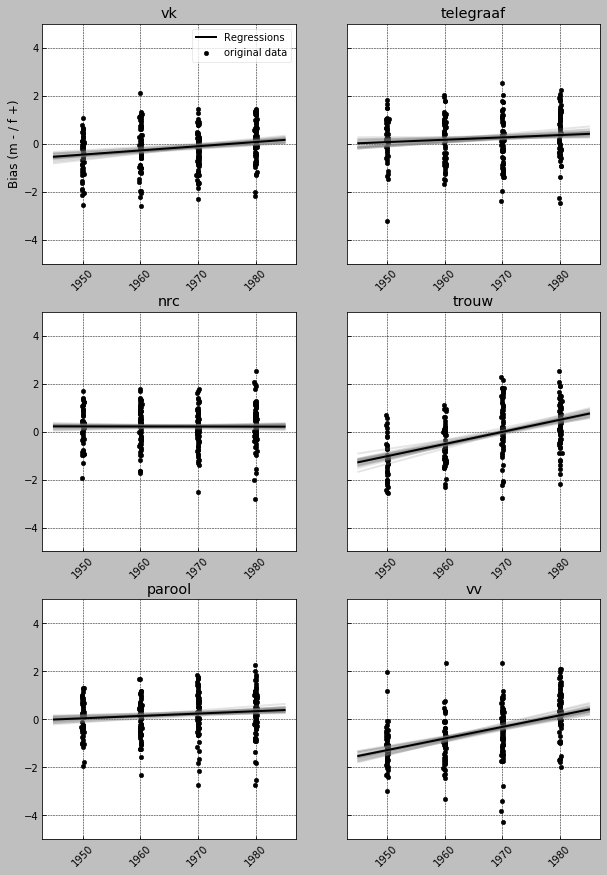

In [230]:
# targets_ = [pos_words, neg_words, job_titles]
# names = ['positive_words', 'negative_words', 'job_titles']
targets_ = [LIWC['Sexual']]
names = ['Sexual']
for i, target in enumerate(targets_):
    name = names[i]
    print(name)
    df = calculate_distances(male_x, female_x, target)

    words = df['words'].unique()
    z = pd.Categorical(df['words'])
    df['word_id'] = z.codes
    word_idx = df['word_id'].values

    newspaper_names = df['titles'].unique()
    z = pd.Categorical(df['titles'])
    df['newspaper_id'] = z.codes
    newspaper_idx = df['newspaper_id'].values
    
    traces, summary = individual_newspapers(df, chains=1)
    summaries[name] = summary
    plot_individual_traces(traces, name)

In [213]:
models = []
categories = list(LIWC.columns.values) + names
for category in categories: 
    temp_df = pd.concat(summaries[category].values(), keys=summaries[category].keys())
    temp_df['category'] = category
    temp_df.drop(['mc_error'], axis=1, inplace=True)
    models.append(temp_df)
model_summary_indiv = pd.concat(models)
print(model_summary_indiv.sort_index().to_latex())

\begin{tabular}{llrrrrl}
\toprule
   &    &   mean &     sd &  hpd\_2.5 &  hpd\_97.5 &        category \\
\midrule
nrc & a &  0.649 &  0.049 &    0.567 &     0.758 &          Affect \\
   & a &  0.572 &  0.049 &    0.482 &     0.667 &          Posemo \\
   & a &  0.701 &  0.050 &    0.605 &     0.800 &          Negemo \\
   & a &  0.797 &  0.054 &    0.684 &     0.901 &             Anx \\
   & a &  0.687 &  0.050 &    0.592 &     0.787 &           Anger \\
   & a &  0.648 &  0.055 &    0.553 &     0.761 &             Sad \\
   & a &  0.631 &  0.044 &    0.545 &     0.711 &          Senses \\
   & a &  0.474 &  0.050 &    0.379 &     0.567 &          Social \\
   & a &  0.480 &  0.045 &    0.386 &     0.561 &           Occup \\
   & a &  0.485 &  0.047 &    0.401 &     0.577 &         Leisure \\
   & a &  0.465 &  0.095 &    0.288 &     0.653 &            Home \\
   & a &  0.487 &  0.075 &    0.325 &     0.621 &          Sports \\
   & a &  0.290 &  0.158 &   -0.018 &     0.585 &       

In [127]:
model_summary_indiv

mean     sd  hpd_2.5  hpd_97.5        category
vk        a  -0.136  0.049   -0.224    -0.040          Affect
          bY  0.016  0.025   -0.029     0.064          Affect
telegraaf a   0.606  0.062    0.496     0.729          Affect
          bY -0.298  0.032   -0.358    -0.231          Affect
nrc       a   0.649  0.049    0.567     0.758          Affect
          bY -0.384  0.026   -0.431    -0.331          Affect
trouw     a  -0.089  0.059   -0.192     0.032          Affect
          bY  0.051  0.030   -0.010     0.107          Affect
parool    a   0.602  0.051    0.515     0.701          Affect
          bY -0.341  0.027   -0.390    -0.290          Affect
vv        a  -0.480  0.057   -0.589    -0.370          Affect
          bY  0.006  0.031   -0.051     0.065          Affect
vk        a  -0.211  0.047   -0.312    -0.128          Posemo
          bY  0.067  0.027    0.011     0.115          Posemo
telegraaf a   0.502  0.061    0.388     0.622          Posemo
          bY -0.190  0.033   -0.248    -0.124          Posemo
nrc       a   0.572  0.049    0.482     0.667          Posemo
          bY -0.308  0.026   -0.359    -0.258          Posemo
trouw     a  -0.234  0.048   -0.331    -0.149          Posemo
          bY  0.113  0.026    0.067     0.163          Posemo
parool    a   0.594  0.049    0.496     0.686          Posemo
          bY -0.335  0.027   -0.387    -0.283          Posemo
vv        a  -0.640  0.055   -0.752    -0.531          Posemo
          bY  0.085  0.029    0.026     0.139          Posemo
vk        a  -0.098  0.055   -0.202     0.014          Negemo
          bY -0.015  0.029   -0.066     0.045          Negemo
telegraaf a   0.649  0.067    0.527     0.784          Negemo
          bY -0.337  0.037   -0.409    -0.265          Negemo
nrc       a   0.701  0.050    0.605     0.800          Negemo
          bY -0.413  0.027   -0.462    -0.359          Negemo
...             ...    ...      ...       ...             ...
trouw     a  -0.279  0.043   -0.361    -0.192  positive_words
          bY  0.206  0.022    0.164     0.250  positive_words
parool    a   0.479  0.041    0.401     0.554  positive_words
          bY -0.273  0.022   -0.313    -0.229  positive_words
vv        a  -0.867  0.044   -0.950    -0.781  positive_words
          bY  0.217  0.023    0.179     0.266  positive_words
vk        a  -0.066  0.035   -0.134    -0.003  negative_words
          bY -0.018  0.018   -0.049     0.019  negative_words
telegraaf a   0.631  0.046    0.542     0.717  negative_words
          bY -0.317  0.024   -0.362    -0.273  negative_words
nrc       a   0.662  0.032    0.604     0.720  negative_words
          bY -0.384  0.017   -0.415    -0.348  negative_words
trouw     a  -0.150  0.042   -0.246    -0.084  negative_words
          bY  0.115  0.021    0.074     0.153  negative_words
parool    a   0.638  0.038    0.563     0.716  negative_words
          bY -0.378  0.019   -0.417    -0.346  negative_words
vv        a  -0.633  0.039   -0.704    -0.558  negative_words
          bY  0.069  0.021    0.029     0.109  negative_words
vk        a  -0.030  0.026   -0.082     0.020      job_titles
          bY  0.028  0.013    0.003     0.053      job_titles
telegraaf a  -0.020  0.030   -0.079     0.039      job_titles
          bY -0.049  0.016   -0.077    -0.017      job_titles
nrc       a   0.181  0.022    0.134     0.222      job_titles
          bY -0.131  0.012   -0.154    -0.106      job_titles
trouw     a  -0.404  0.028   -0.460    -0.354      job_titles
          bY  0.207  0.015    0.180     0.236      job_titles
parool    a  -0.053  0.025   -0.097    -0.001      job_titles
          bY -0.009  0.014   -0.032     0.022      job_titles
vv        a  -0.667  0.023   -0.707    -0.617      job_titles
          bY  0.242  0.013    0.218     0.269      job_titles

[300 rows x 5 columns]

In [140]:
bY = model_summary_indiv.loc[(model_summary_indiv.index.get_level_values(level=1) == 'bY')].sort_index()

In [183]:
bY.loc[(bY['hpd_2.5'] < 0.00) &(bY['hpd_97.5'] > 0.00)]

mean     sd  hpd_2.5  hpd_97.5        category
nrc       bY -0.090  0.084   -0.240     0.074              TV
          bY  0.012  0.046   -0.073     0.098          Sexual
parool    bY  0.001  0.097   -0.172     0.208              TV
          bY -0.063  0.057   -0.160     0.056           Music
          bY  0.091  0.054   -0.004     0.194          Sexual
          bY -0.009  0.014   -0.032     0.022      job_titles
telegraaf bY  0.131  0.096   -0.049     0.340              TV
          bY  0.085  0.066   -0.031     0.205           Music
          bY  0.004  0.039   -0.072     0.081          Metaph
          bY  0.080  0.065   -0.039     0.203          Sexual
trouw     bY  0.051  0.030   -0.010     0.107          Affect
          bY  0.036  0.033   -0.029     0.097          Negemo
          bY  0.047  0.033   -0.017     0.109             Anx
          bY  0.021  0.034   -0.043     0.087             Sad
          bY  0.060  0.054   -0.039     0.171          Sports
          bY  0.006  0.031   -0.050     0.062           Money
          bY  0.125  0.080   -0.048     0.273           Groom
vk        bY  0.016  0.025   -0.029     0.064          Affect
          bY -0.015  0.029   -0.066     0.045          Negemo
          bY -0.058  0.033   -0.121     0.011             Anx
          bY -0.028  0.028   -0.075     0.032           Anger
          bY  0.011  0.026   -0.036     0.070             Sad
          bY  0.019  0.027   -0.032     0.071          Senses
          bY  0.047  0.029   -0.006     0.105          Social
          bY  0.090  0.056   -0.014     0.197            Home
          bY  0.101  0.056   -0.003     0.219           Music
          bY  0.026  0.029   -0.029     0.083         Physcal
          bY  0.039  0.029   -0.015     0.096            Body
          bY  0.023  0.039   -0.046     0.102          Eating
          bY -0.004  0.053   -0.107     0.102           Sleep
          bY -0.018  0.018   -0.049     0.019  negative_words
vv        bY  0.006  0.031   -0.051     0.065          Affect
          bY -0.049  0.034   -0.113     0.010          Negemo
          bY -0.050  0.034   -0.118     0.016             Anx
          bY  0.030  0.032   -0.034     0.090           Anger
          bY -0.027  0.034   -0.093     0.041             Sad
          bY  0.023  0.083   -0.127     0.203           Groom

In [194]:
pos = bY.loc[bY['hpd_2.5'] > 0.00]
neg = bY.loc[bY['hpd_97.5'] < 0.00]
equal = bY.loc[(bY['hpd_2.5'] < 0.00) &(bY['hpd_97.5'] > 0.00)]


In [196]:
total = bY.groupby([bY.index.get_level_values(0)])['mean'].count()
print(total)
print('----')
pos_change = pos.groupby([pos.index.get_level_values(0)])['mean'].count()
print(pos_change)
print('----')
neg_change = neg.groupby([neg.index.get_level_values(0)])['mean'].count()
print(neg_change)
print('----')
no_change = equal.groupby([equal.index.get_level_values(0)])['mean'].count()
print(no_change)

nrc          25
parool       25
telegraaf    25
trouw        25
vk           25
vv           25
Name: mean, dtype: int64
----
parool     1
trouw     18
vk         9
vv        18
Name: mean, dtype: int64
----
nrc          23
parool       20
telegraaf    21
vk            2
vv            1
Name: mean, dtype: int64
----
nrc           2
parool        4
telegraaf     4
trouw         7
vk           14
vv            6
Name: mean, dtype: int64


In [198]:
pd.concat(neg_change, pos_change)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "Series"

## Inspect Bias

In [ ]:
def plot_differences(list1, list2, model, features):
    features = [word for word in features if word in model.vocab]
    v1 = np.mean([model[word] for word in list1 if word in model.vocab], axis=0)
    v2 = np.mean([model[word] for word in list2 if word in model.vocab], axis=0)
    x = []
    y = []
    for word in features:
        x.append(calc_distance_between_vectors(model[word], v1))
        y.append(calc_distance_between_vectors(model[word], v2))
    C = [x_ - y_ for x_, y_ in zip(x, y)]
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xlabel('distance to male')
    plt.ylabel('distance to female')
    plt.ylim(min(y) - 0.05, max(y) + 0.05)
    plt.xlim(min(y) - 0.05, max(y) +0.05)
    top_idx = np.argsort(C)[-25:]
    bottom_idx = np.argsort(C)[:25]
    for i, label in enumerate(features):
        if i in top_idx or i in bottom_idx:
            ax.annotate(label, (x[i], y[i]))
    ax.plot([min(y) -0.05, max(x) +0.05], [min(y) -0.05, max(x) + 0.05], ls="--", c=".3")
    return C

In [ ]:
plot_differences(male_x, female_x, models_vk[3], LIWC['Anx']);